In [2]:
# UTILS FUNCTIONS AND GLOBAL VARIABLES

import pandas as pd

STATE_NAMES = ["Alaska", "Alabama", "Arkansas", "Arizona", "California",
"Colorado", "Connecticut", "Delaware", "Florida", "Georgia",
"Hawaii", "Iowa", "Idaho", "Illinois", "Indiana", "Kansas", "Kentucky", "Louisiana",
"Massachusetts", "Maryland", "Maine", "Michigan", "Minnesota", "Missouri", "Mississippi",
"Montana", "North Carolina", "North Dakota", "Nebraska", "New Hampshire", "New Jersey",
"New Mexico", "Nevada", "New York", "Ohio", "Oklahoma", "Oregon", "Pennsylvania",
"Rhode Island", "South Carolina", "South Dakota", "Tennessee", "Texas", "Utah", "Virginia",
"Vermont", "Washington", "Wisconsin", "West Virginia", "Wyoming"]

STATE_NAMES_AND_UNITED_STATES = STATE_NAMES[:]
STATE_NAMES_AND_UNITED_STATES.append("United States")

us_state_abbreviations = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
}

US_STATE_CODES = dict(map(reversed, us_state_abbreviations.items()))

NAICS_SECTOR_CODES = {
    "Agriculture, Forestry, Fishing and Hunting" : ("11",),
    "Mining, Quarrying, and Oil and Gas Extraction" : ("21",),
    "Utilities" : ("22",),
    "Construction" : ("23",),
    "Manufacturing" : ("31", "32", "33",),
    "Wholesale Trade" : ("42",),
    "Retail Trade" : ("44", "45",),
    "Transportation and Warehousing" : ("48", "49",),
    "Information" : ("51",),
    "Finance and Insurance" : ("52",),
    "Real Estate and Rental and Leasing" : ("53",),
    "Professional, Scientific, and Technical Services" : ("54",),
    "Administrative and Support and Waste Management and Remediation Services" : ("56",),
    "Educational Services" : ("61",),
    "Health Care and Social Assistance" : ("62",),
    "Arts, Entertainment, and Recreation" : ("71",),
    "Accommodation and Food Services" : ("72",),
    "Other Services (except Public Administration)" : ("81",),
    "Public Administration (not covered in economic census)" : ("92",)
}

def combine_dataframes_by_state(main_df, df_lst):
    """
    Recursively concatenates multiple panda dataframes (with "State" 
    as the index) with only the required columns

    Inputs:
        df_lst (lst of tuples): (df, [cols to extract])
        ### If extracting all columns, [cols to extract] should be 
        an empty list ###
        
    Returns:
        final_df (pandas series): concatenated pandas dataframes
    """
    if len(df_lst) == 0:
        return main_df

    other_df, col_lst = df_lst.pop()
    if col_lst != []:
        new_df = main_df.merge(other_df[col_lst], on="State")
    else:
        new_df = main_df.merge(other_df, on="State")
    
    return combine_dataframes_by_state(new_df, df_lst)

In [82]:
import pandas as pd
from utils_clean_and_analyze import STATE_NAMES, STATE_NAMES_AND_UNITED_STATES, US_STATE_CODES, NAICS_SECTOR_CODES

def clean_census_expenditure(df):
    """
    ###
    """

    df['Description'] = df['Description'].str.strip()

    df.rename(columns = {'United States Total':'United States'}, inplace = True)

    # Retains only columns with combined state and local government expenditure
    df = df[["Description"] + STATE_NAMES_AND_UNITED_STATES]

    # Drops rows relating to state revenue sources
    df.drop(df.index[0:66], inplace=True)

    social = ["Public welfare", "Hospitals", "Health", "Employment security administration", "Veterans' services"]
    educ = ["Education", "Libraries"]
    govt = ["Financial administration", "Judicial and legal", "General public buildings", "Other governmental administration"]
    transport = ["Highways", "Air transportation (airports)", "Parking facilities", "Sea and inland port facilities"]
    others = ["Utility expenditure", "Expenditure1"]

    # Retains only required rows
    df = df[df["Description"].isin(social + educ + govt + transport + others)]

    # Transposes dataframe and sets new column names
    df = df.transpose()
    df.columns = df.iloc[0]
    df = df[1:]
    df.reset_index(inplace=True)
    df.rename(columns = {'Expenditure1':'State Expenditure', 
    "index" : "State", "Utility expenditure" : "Utilities"}, inplace = True)

    # Converts specific columns in to integers
    for col in [col for col in df.columns]:
        if col != "State":
            df[col] = df[col].str.replace(',','')
            df[col] = df[col].astype(int)
    
    # Merges sub-categories into single categories
    df["Health and Social Services Expenditure"] = df[social].sum(axis=1)
    df["Education Related Expenditure"] = df[educ].sum(axis=1)
    df["Public Administration Expenditure"] = df[educ].sum(axis=1)
    df["Transportation Expenditure"] = df[transport].sum(axis=1)
    df.drop(columns = social + educ + govt + transport, inplace=True)

    required_col_names = [col for col in df.columns[1:]]

    for col in required_col_names:

        # Calculates state expenditure in one cateogry as a proportion
        # of total US expenditure for this category
        if col == "State Expenditure":
            df["State Total as % of US Total"] = \
                df.apply(lambda x : (x[col] / int(df.loc[df["State"] ==
                    "United States", col])) * 100, axis = 1)

        # Calculates the state expenditure in one category as a proportion
        # of total state expenditure across all cateogries
        else:
            df[col + " (State as % of US)"] = \
                df.apply(lambda x : (x[col] / int(df.loc[df["State"] ==
                    "United States", col])) * 100, axis = 1)

            df[col + " (% of Total Expenditure)"] = (df[col] /
            df["State Expenditure"] * 100)

    # Sets "State" column as index of dataframe
    df.set_index(["State"], inplace = True)

    return df


def clean_census_population(pop_df):
    """
    ###
    """
    pop_df = pop_df.iloc[:,0:2]
    pop_df.columns = ["State", "Population"]
    pop_df['State'] = pop_df['State'].str.strip()
    pop_df = pop_df[pop_df["State"].isin(STATE_NAMES_AND_UNITED_STATES)]
    pop_df["Population"] = pop_df["Population"].str.replace(',','')
    pop_df["Population"] = pop_df["Population"].astype(int)
    pop_df.set_index("State", inplace=True)

    return pop_df


def clean_census_poverty(poverty_df):
    """
    ###
    """
    poverty_df = poverty_df.iloc[:,0:2]
    poverty_df.columns = ["State", "3-Year Average Poverty Rate (2018-2020)"]
    poverty_df['State'] = poverty_df['State'].str.strip()
    poverty_df = poverty_df[poverty_df["State"].isin(STATE_NAMES_AND_UNITED_STATES)]
    poverty_df.set_index("State", inplace=True)

    return poverty_df

def clean_funding(raw_funding_df):
    """
    ###
    """
    raw_funding_df["code"] = raw_funding_df["code"].astype(str)

    # Creates structure for funding dataframe
    naics_sector_lst = [k for k in NAICS_SECTOR_CODES.keys()]
    funding_df = pd.DataFrame(STATE_NAMES_AND_UNITED_STATES, columns=["State"])
    funding_df = pd.concat([funding_df,pd.DataFrame(columns = naics_sector_lst)])

    # Calculates funding for each category in each state and inputs values into funding_df
    for state_code, state in US_STATE_CODES.items():
        for sector, naics_code_tuple in NAICS_SECTOR_CODES.items():
            if len(naics_code_tuple) == 1:
                subset_df = raw_funding_df[(raw_funding_df["code"].apply(lambda x : x.startswith(naics_code_tuple[0]))) & (raw_funding_df["State"] == state_code) & (raw_funding_df["amount"] >= 0)]
                sum_val = subset_df["amount"].sum() / 1000
            else:
                sum_val = 0
                for naics_code in naics_code_tuple:
                    subset_df = raw_funding_df[(raw_funding_df["code"].apply(lambda x : x.startswith(naics_code))) & (raw_funding_df["State"] == state_code) & (raw_funding_df["amount"] >= 0)]
                    sum_val += subset_df["amount"].sum() / 1000
            
            funding_df.loc[funding_df["State"] == state, sector] = int(sum_val)

    required_col_names = [col for col in funding_df.columns[1:]]

    # Calculates total funding across categories for each state
    funding_df["State Total (All Categories)"] = funding_df[required_col_names].sum(axis=1)

    for col in required_col_names:
        # Calculates total funding for each category at the national level
        funding_df.loc[funding_df["State"] == "United States", col] = funding_df[col].sum()

        # Calculates funding for each state as a share of US by category
        funding_df[col + " (State as % of US)"] = funding_df.apply(lambda x : (x[col] / funding_df.loc[funding_df["State"] == "United States", col]) * 100, axis = 1)

        # Calculates funding for each category as a share of the total funding received by a state
        funding_df_without_us = funding_df.iloc[0:len(funding_df)-1]
        funding_df[col + " (as % of Total Funding Received by State)"] = (funding_df_without_us[col] / funding_df_without_us["State Total (All Categories)"]) * 100

    funding_df.drop(columns = naics_sector_lst, inplace = True)
    funding_df.set_index("State", inplace=True)

    return funding_df

In [10]:
# CLEANS CENSUS EXPENDITURE

df = pd.read_csv("2020_us_state_finances.csv")
df['Description'] = df['Description'].str.strip()

df.rename(columns = {'United States Total':'United States'}, inplace = True)

# Retains only columns required
df = df[["Description"] + STATE_NAMES_AND_UNITED_STATES]
# df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# Drops rows relating to revenue sources
df.drop(df.index[0:66], inplace=True)

social = ["Public welfare", "Hospitals", "Health", "Employment security administration", "Veterans' services"]
educ = ["Education", "Libraries"]
govt = ["Financial administration", "Judicial and legal", "General public buildings", "Other governmental administration"]
transport = ["Highways", "Air transportation (airports)", "Parking facilities", "Sea and inland port facilities"]
others = ["Utility expenditure", "Expenditure1"]

# Retains only required rows
df = df[df["Description"].isin(social + educ + govt + transport + others)]

# # Education (Education + Libraries) - 61
# # Health & Social Services (Public welfare + Hospitals + Health + Security + Employment security administration +  Veterans' services) - 62
# # Government Administration (Financial administration + Judicial and legal + General public buildings + Other governmental administration) - 92
# # Utilities (Utility expenditure) - 22
# # Transportation (Highways, Air transportation (airports), Parking facilities, Sea and inland port facilities) - 48/49

# # Transposes dataframe and rename columns
df = df.transpose()
df.columns = df.iloc[0]
df = df[1:]
df.reset_index(inplace=True)
df.rename(columns = {'Expenditure1':'State Expenditure (in thousands)', 
"index" : "State", "Utility expenditure" : "Utilities"}, inplace = True)

for col in [col for col in df.columns]:
    if col != "State":
        df[col] = df[col].str.replace(',','')
        df[col] = df[col].astype(int)

df["Health and Social Services Expenditure"] = df[social].sum(axis=1)
df["Education Related Expenditure"] = df[educ].sum(axis=1)
df["Public Administration Expenditure"] = df[educ].sum(axis=1)
df["Transportation Expenditure"] = df[transport].sum(axis=1)
df.drop(columns = social + educ + govt + transport, inplace=True)

required_col_names = [col for col in df.columns[1:]]

for col in required_col_names:
    if col == "State Expenditure":
        df["State Total as % of US Total"] = \
            df.apply(lambda x : (x[col] / int(df.loc[df["State"] ==
                "United States", col])) * 100, axis = 1)

    else:
        df[col + " (State as % of US)"] = \
            df.apply(lambda x : (x[col] / int(df.loc[df["State"] ==
                "United States", col])) * 100, axis = 1)

        df[col + " (% of Total Expenditure)"] = (df[col] /
        df["State Expenditure"] * 100)

df.set_index(["State"], inplace = True)

df

Description,State Expenditure,Utilities,Health and Social Services,Education Related,Public Administration,Transportation,State Total as % of US Total,Utilities (State as % of US),Utilities (% of Total Expenditure),Health and Social Services (State as % of US),Health and Social Services (% of Total Expenditure),Education Related (State as % of US),Education Related (% of Total Expenditure),Public Administration (State as % of US),Public Administration (% of Total Expenditure),Transportation (State as % of US),Transportation (% of Total Expenditure)
State,,,,,,,,,,,,,,,,,
Alaska,15076507,662585,3432117,3123400,3123400,1871269,0.356387,0.259708,4.394818,0.300677,22.764670,0.272825,20.717000,0.272825,20.717000,0.758438,12.411821
Alabama,52646924,3328580,16217017,15342284,15342284,3035451,1.244498,1.304678,6.322459,1.420720,30.803351,1.340129,29.141843,1.340129,29.141843,1.230288,5.765676
Arkansas,28980661,997150,9267271,8981653,8981653,1954279,0.685062,0.390845,3.440743,0.811875,31.977431,0.784536,30.991885,0.784536,30.991885,0.792082,6.743390
Arizona,71488388,6437486,19448164,19820840,19820840,3892365,1.689884,2.523252,9.004939,1.703790,27.204648,1.731326,27.725957,1.731326,27.725957,1.577601,5.444751
California,678462621,47236140,203249197,161448285,161448285,29738225,16.037890,18.514786,6.962232,17.805999,29.957317,14.102306,23.796195,14.102306,23.796195,12.053099,4.383178
Colorado,74023492,4609612,15038879,20290185,20290185,4807637,1.749810,1.806794,6.227229,1.317507,20.316360,1.772322,27.410467,1.772322,27.410467,1.948567,6.494745
Connecticut,45285851,1423391,6582163,14260766,14260766,2177743,1.070493,0.557916,3.143125,0.576642,14.534701,1.245660,31.490555,1.245660,31.490555,0.882654,4.808882
Delaware,13311734,611023,3443842,4494531,4494531,767628,0.314670,0.239498,4.590108,0.301704,25.870724,0.392592,33.763678,0.392592,33.763678,0.311125,5.766552
Florida,208234166,12233643,50051526,50274090,50274090,16427556,4.922359,4.795127,5.874945,4.384851,24.036174,4.391379,24.143055,4.391379,24.143055,6.658197,7.888982


In [4]:
# CLEANS CENSUS POPULATION

pop_df = pd.read_csv("us_census_population.csv")
pop_df = pop_df.iloc[:,0:2]
pop_df.columns = ["State", "2020 Census Population"]
pop_df['State'] = pop_df['State'].str.strip()
pop_df = pop_df[pop_df["State"].isin(STATE_NAMES_AND_UNITED_STATES)]

pop_df["2020 Census Population"] = pop_df["2020 Census Population"].str.replace(',','')
pop_df["2020 Census Population"] = pop_df["2020 Census Population"].astype(int)

pop_df.set_index("State", inplace=True)

pop_df


,2020 Census Population
State,
United States,331449520
Alabama,5024356
Alaska,733378
Arizona,7151507
Arkansas,3011555
California,39538245
Colorado,5773733
Connecticut,3605942
Delaware,989957


In [100]:
# CLEANS CENSUS POVERTY

poverty_df = pd.read_csv("us_poverty_by_state.csv")
poverty_df = poverty_df.iloc[:,0:2]
poverty_df.columns = ["State", "Poverty Rate (2018-2020)"]
poverty_df['State'] = poverty_df['State'].str.strip()
poverty_df = poverty_df[poverty_df["State"].isin(STATE_NAMES_AND_UNITED_STATES)]

poverty_df["Poverty Rate (2018-2020)"] = poverty_df["Poverty Rate (2018-2020)"].astype(float)

poverty_df.set_index("State", inplace=True)

poverty_df

,Poverty Rate (2018-2020)
State,
United States,11.2
Alabama,14.6
Alaska,12.2
Arizona,11.2
Arkansas,14.7
California,11.0
Colorado,9.3
Connecticut,9.9
Delaware,8.1


In [6]:
# COMBINES MULTIPLE DATAFRAMES INTO ONE

df_lst = [(poverty_df, []), (pop_df, [])]

combine_dataframes_by_state(df, df_lst)

,State Expenditure,Utilities,Health and Social Services,Education Related,Public Administration,Transportation,State Total as % of US Total,Utilities (State as % of US),Utilities (% of Total Expenditure),Health and Social Services (State as % of US),Health and Social Services (% of Total Expenditure),Education Related (State as % of US),Education Related (% of Total Expenditure),Public Administration (State as % of US),Public Administration (% of Total Expenditure),Transportation (State as % of US),Transportation (% of Total Expenditure),2020 Census Population,3-Year Average Poverty Rate (2018-2020)
State,,,,,,,,,,,,,,,,,,,
Alaska,15076507,662585,3432117,3123400,3123400,1871269,0.356387,0.259708,4.394818,0.300677,22.764670,0.272825,20.717000,0.272825,20.717000,0.758438,12.411821,733378,12.2
Alabama,52646924,3328580,16217017,15342284,15342284,3035451,1.244498,1.304678,6.322459,1.420720,30.803351,1.340129,29.141843,1.340129,29.141843,1.230288,5.765676,5024356,14.6
Arkansas,28980661,997150,9267271,8981653,8981653,1954279,0.685062,0.390845,3.440743,0.811875,31.977431,0.784536,30.991885,0.784536,30.991885,0.792082,6.743390,3011555,14.7
Arizona,71488388,6437486,19448164,19820840,19820840,3892365,1.689884,2.523252,9.004939,1.703790,27.204648,1.731326,27.725957,1.731326,27.725957,1.577601,5.444751,7151507,11.2
California,678462621,47236140,203249197,161448285,161448285,29738225,16.037890,18.514786,6.962232,17.805999,29.957317,14.102306,23.796195,14.102306,23.796195,12.053099,4.383178,39538245,11.0
Colorado,74023492,4609612,15038879,20290185,20290185,4807637,1.749810,1.806794,6.227229,1.317507,20.316360,1.772322,27.410467,1.772322,27.410467,1.948567,6.494745,5773733,9.3
Connecticut,45285851,1423391,6582163,14260766,14260766,2177743,1.070493,0.557916,3.143125,0.576642,14.534701,1.245660,31.490555,1.245660,31.490555,0.882654,4.808882,3605942,9.9
Delaware,13311734,611023,3443842,4494531,4494531,767628,0.314670,0.239498,4.590108,0.301704,25.870724,0.392592,33.763678,0.392592,33.763678,0.311125,5.766552,989957,8.1
Florida,208234166,12233643,50051526,50274090,50274090,16427556,4.922359,4.795127,5.874945,4.384851,24.036174,4.391379,24.143055,4.391379,24.143055,6.658197,7.888982,21538226,12.8


In [61]:
# CLEANS FUNDING DATA
raw_funding_df = pd.read_csv("2016_us_funding.csv")
raw_funding_df["code"] = raw_funding_df["code"].astype(str)

# Creates structure for funding dataframe
naics_sector_lst = [k for k in NAICS_SECTOR_CODES.keys()]
funding_df = pd.DataFrame(STATE_NAMES_AND_UNITED_STATES, columns=["State"])
funding_df = pd.concat([funding_df,pd.DataFrame(columns = naics_sector_lst)])

# Calculates funding for each category in each state and inputs values into funding_df
for state_code, state in US_STATE_CODES.items():
    for sector, naics_code_tuple in NAICS_SECTOR_CODES.items():
        if len(naics_code_tuple) == 1:
            subset_df = raw_funding_df[(raw_funding_df["code"].apply(lambda x : x.startswith(naics_code_tuple[0]))) & (raw_funding_df["State"] == state_code) & (raw_funding_df["amount"] >= 0)]
            sum_val = subset_df["amount"].sum() / 1000
        else:
            sum_val = 0
            for naics_code in naics_code_tuple:
                subset_df = raw_funding_df[(raw_funding_df["code"].apply(lambda x : x.startswith(naics_code))) & (raw_funding_df["State"] == state_code) & (raw_funding_df["amount"] >= 0)]
                sum_val += subset_df["amount"].sum() / 1000
        
        funding_df.loc[funding_df["State"] == state, sector] = int(sum_val)

required_col_names = [col for col in funding_df.columns[1:]]

# Calculates total funding across categories for each state
funding_df["Total Funding Received"] = funding_df[required_col_names].sum(axis=1)

for col in required_col_names:
    # Calculates total funding for each category at the national level
    funding_df.loc[funding_df["State"] == "United States", col] = funding_df[col].sum()

    # Calculates funding for each state as a share of US by category
    funding_df[col + " (State as % of US)"] = funding_df.apply(lambda x : (x[col] / funding_df.loc[funding_df["State"] == "United States", col]) * 100, axis = 1)

    # Calculates funding for each category as a share of the total funding received by a state
    funding_df_without_us = funding_df.iloc[0:len(funding_df)-1]
    funding_df[col + " (as % of Total Funding Received by State)"] = (funding_df_without_us[col] / funding_df_without_us["Total Funding Received"]) * 100

funding_df.drop(columns = naics_sector_lst, inplace = True)

funding_df.set_index("State", inplace=True)

funding_df.to_csv("2016_cleaned_funding.csv")

In [79]:
def clean_and_combine(years):
    """
    ###

    Inputs:
        years (lst of str)

    Returns:
        cleaned_and_combined (dct)
    """

    # Clean poverty data
    poverty_df = clean_census_poverty(pd.read_csv("us_poverty_by_state.csv"))

    # Clean population data
    pop_df = clean_census_population(pd.read_csv("us_census_population.csv"))

    # Clean and combines census data and funding data from each year from 2016 to 2020
    expenditure_file_name = "_us_state_finances.csv"
    funding_file_name = "_us_funding.csv"

    cleaned_and_combined = {}

    for year in years:
        expenditure_csv = str(year) + expenditure_file_name # "2016_us_state_finances.csv"
        funding_csv = str(year) + funding_file_name # "2016_us_funding.csv"

        expenditure_df = clean_census_expenditure(pd.read_csv(expenditure_csv))
        funding_df = clean_funding(pd.read_csv(funding_csv))

        if year == "2020":
            cleaned_and_combined[year] = combine_dataframes_by_state(expenditure_df, [(funding_df, []), (pop_df, []), (poverty_df, [])])

        else:
            cleaned_and_combined[year] = combine_dataframes_by_state(expenditure_df, [(funding_df, []), (pop_df, [])])
    
    return cleaned_and_combined

In [83]:
sample = clean_and_combine(["2016"])
sample["2016"]

/tmp/user/23111/ipykernel_4065433/3908198172.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  poverty_df['State'] = poverty_df['State'].str.strip()
/tmp/user/23111/ipykernel_4065433/3908198172.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pop_df['State'] = pop_df['State'].str.strip()
/tmp/user/23111/ipykernel_4065433/3908198172.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

,State Expenditure,Utilities,Health and Social Services Expenditure,Education Related Expenditure,Public Administration Expenditure,Transportation Expenditure,State Total as % of US Total,Utilities (State as % of US)_x,Utilities (% of Total Expenditure),Health and Social Services Expenditure (State as % of US),...,Health Care and Social Assistance (State as % of US),Health Care and Social Assistance (as % of Total Funding Received by State),"Arts, Entertainment, and Recreation (State as % of US)","Arts, Entertainment, and Recreation (as % of Total Funding Received by State)",Accommodation and Food Services (State as % of US),Accommodation and Food Services (as % of Total Funding Received by State),Other Services (except Public Administration) (State as % of US),Other Services (except Public Administration) (as % of Total Funding Received by State),Public Administration (not covered in economic census) (State as % of US),Public Administration (not covered in economic census) (as % of Total Funding Received by State)
State,,,,,,,,,,,,,,,,,,,,,
Alaska,15839199,830825,2983373,3588591,3588591,2059193,0.448344,0.371693,5.245373,0.318966,...,0.053719,0.124236,0.765051,0.021253,1.260235,0.392485,0.391874,0.295942,2.165824,0.459859
Alabama,47285873,3002048,15285779,13697154,13697154,2658932,1.338472,1.343051,6.348721,1.634275,...,1.527035,1.187468,0.211649,0.001977,1.869921,0.195816,1.408550,0.357672,0.716867,0.051179
Arkansas,26782688,987246,8445575,8456323,8456323,1876958,0.758110,0.441672,3.686135,0.902956,...,0.220687,4.075734,0.033900,0.007521,0.161003,0.400419,0.066835,0.403061,0.185930,0.315254
Arizona,56101988,5537984,14832578,14711408,14711408,2973625,1.588021,2.477573,9.871279,1.585821,...,19.427838,13.722323,1.392668,0.011816,1.649339,0.156879,1.853238,0.427439,0.710513,0.046074
California,550055846,40883140,161625554,126135404,126135404,22916107,15.569859,18.290224,7.432543,17.280148,...,17.014897,2.56287,4.392403,0.007947,5.500412,0.111569,11.611100,0.571098,22.465853,0.310672
Colorado,57851779,4549461,11803799,16620488,16620488,3792070,1.637550,2.035329,7.863995,1.262000,...,3.479309,2.883638,1.370679,0.013646,1.448780,0.161697,6.268404,1.696464,0.593872,0.045188
Connecticut,41772915,1501501,6262342,13812769,13812769,2663902,1.182422,0.671739,3.594437,0.669536,...,0.332384,0.221404,0.675261,0.005403,0.661828,0.059367,0.738417,0.160615,0.309403,0.018921
Delaware,11268907,547992,2999430,3729041,3729041,662993,0.318977,0.245160,4.862867,0.320683,...,0.030277,0.697034,0.214398,0.05929,0.272642,0.845259,0.167879,1.262061,0.028291,0.059796
Florida,167777134,10945998,40697684,42068401,42068401,13752966,4.749093,4.897000,6.524130,4.351181,...,5.536434,2.944664,11.016740,0.070384,4.344134,0.311143,7.744733,1.345092,12.528860,0.611785


In [148]:
year_df = sample["2016"]
year_df = year_df.merge(poverty_df, on="State")

year_df["Expenditure per Capita (in thousands)"] = year_df["State Expenditure"] / year_df["Population"]
year_df["Funding received per Capita (in thousands)"] = year_df["State Total (All Categories)"] / year_df["Population"]

year_df[["Funding received per Capita (in thousands)", "Expenditure per Capita (in thousands)"]]

,Funding received per Capita (in thousands),Expenditure per Capita (in thousands)
State,,
Alaska,5.357142,21.597592
Alabama,2.325560,9.411330
Arkansas,0.163366,8.893309
Arizona,1.798789,7.844778
California,1.525690,13.911994
Colorado,1.898788,10.019822
Connecticut,3.782827,11.584467
Delaware,0.398676,11.383229
Florida,0.793169,7.789738


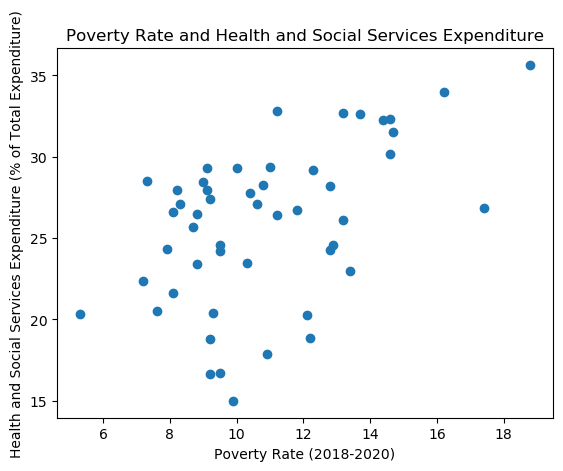

In [151]:
year_df[["Funding received per Capita (in thousands)", "Expenditure per Capita (in thousands)"]]

import matplotlib.pyplot as plt

y_axis = year_df.iloc[:50]["Health and Social Services Expenditure (% of Total Expenditure)"]
x_axis = year_df.iloc[:50]["Poverty Rate (2018-2020)"]

plt.scatter(x_axis, y_axis, marker = "o")
plt.title("Poverty Rate and Health and Social Services Expenditure")
plt.xlabel("Poverty Rate (2018-2020)")
plt.ylabel("Health and Social Services Expenditure (% of Total Expenditure)")
plt.show()


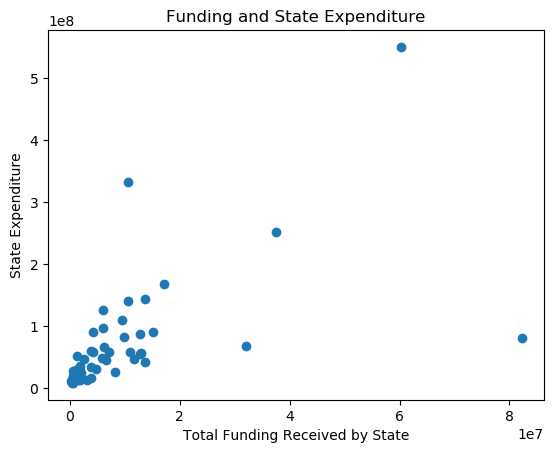

In [150]:
y_axis = year_df.iloc[:50]["State Expenditure"]
x_axis = year_df.iloc[:50]["State Total (All Categories)"]

year_df["State Total (All Categories)"]

plt.scatter(x_axis, y_axis, marker = "o")
plt.title("Funding Received and State Expenditure")
plt.xlabel("Total Funding Received by State")
plt.ylabel("State Expenditure")
plt.show()

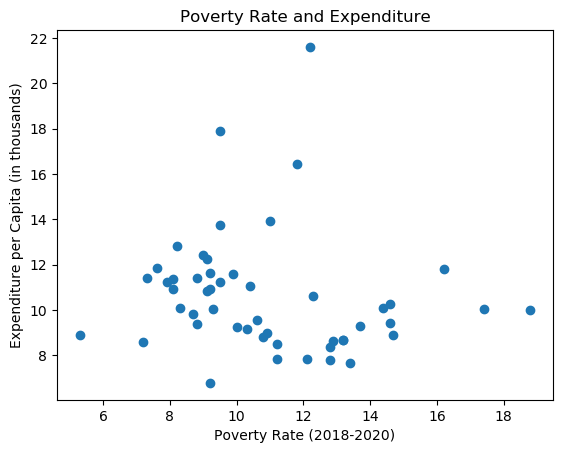

In [137]:
import matplotlib.pyplot as plt

y_axis = year_df.iloc[:50]["Expenditure per Capita (in thousands)"]
x_axis = year_df.iloc[:50]["Poverty Rate (2018-2020)"]

plt.scatter(x_axis, y_axis, marker = "o")
plt.title("Poverty Rate and Expenditure")
plt.xlabel("Poverty Rate (2018-2020)")
plt.ylabel("Expenditure per Capita (in thousands)")
plt.show()
